# Worked out example solution for homework on interpolation

The equation of interest is

$$P = \frac{k_B \rho T}{\mu_I m_u} + \frac{1}{3} a T^4 + K \left (\frac{\rho}{1~\mathrm{g~cm^{-3}}} \right )^{5/3} \mu_e^{-5/3}$$

Set some initial constants and define the equation in code

In [1]:
k_b = 1.38e-16
a = 7.56e-15
mu_I = 1.26
mu_e = 1.15
m_u = 1.66e-24
K = 1e13

In [2]:
def pressure(rho, T):
    return k_b * rho * T / (mu_I * m_u) + (1/3) * a * T**4 + K * rho**(5/3) * mu_e**(-5/3)

Create a 10 by 10 grid in log space for a contour plot. 

In [3]:
N_rho, N_T = 10, 10

In [4]:
import numpy as np

rho = np.logspace(0, 4, N_rho)
T = np.logspace(6, 8, N_T)
rho_g, T_g = np.meshgrid(rho, T, indexing='ij')

`rho_g` and `T_g` are "grid" coordinates: two dimensional arrays corresponding to the grid, but only the x-coordinate values (`rho`) and only the y-coordinate values (`T`)

In [5]:
P = pressure(rho_g, T_g)
P.shape

(10, 10)

Let's create a contour plot, both in linear and logarithmic space

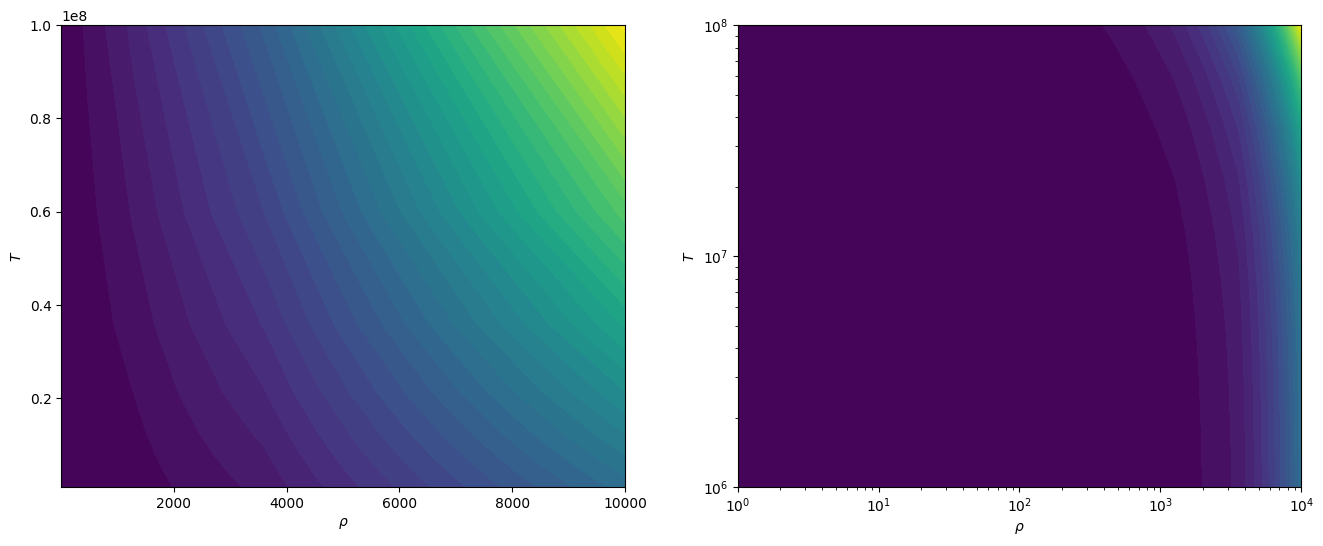

In [6]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].contourf(rho_g, T_g, P, levels=40)
axes[0].set_xlabel(r'$\rho$')
axes[0].set_ylabel(r'$T$')
axes[1].contourf(rho_g, T_g, P, levels=40)
axes[1].set_xlabel(r'$\rho$')
axes[1].set_ylabel(r'$T$')
axes[1].set_xscale('log')
axes[1].set_yscale('log');

## Interpolating the function

The interpolating function is
    
$$P(\rho, T) = a (\rho - \rho_i)(T - T_j) + b (\rho - \rho_i) + c (T - T_j) + d$$

We known four values of P at the four corners in our grid cell. We simply call these values 
$$P_{i,j} = P(\rho_i, T_j)$$
$$P_{i+1, j} = (\rho_{i+1}, T_j)$$
$$P_{i, j+1} = (\rho_i, T_{j+1})$$
$$P_{i+1, j+1} = (\rho_{i+1}, T_{j+1})$$

We fill in the values for $P_n$, $\rho_n$ and $T_n$ into the interpolating function, where $n$ is one of $i$, $j$, $i+1$, $j+1$.

Then for $n == i, j$, the function becomes

$$P(\rho_i, T_j) = a (\rho_i - \rho_i)(T_j - T_j) + b (\rho_i - \rho_i) + c (T_j - T_j) + d$$
or
$$P_{i, j} = a \times 0 \times 0 + b \times 0 + c \times 0 + d$$
or
$$P_{i, j} = d$$
thus
$$d = P_{i, j}$$

Similary, we can calculate $P_{i+1, j}$ and $P_{i, j+1}$, with the obtained value for $d$, which then become
$$P_{i+1, j} = a (\rho_{i+1} - \rho_i)(T_j - T_j) + b (\rho_{i+1} - \rho_i) + c (T_j - T_j) + P_{i, j}$$
which becomes (the $T$ terms become zero again)
$$P_{i+1, j} = b (\rho_{i+1} - \rho_i) + P_{i, j}$$
and thus
$$b = \frac{P_{i+1, j} - P_{i, j}}{(\rho_{i+1} - \rho_i)}$$


and similarly for $c$
$$c = \frac{P_{i, j+1} - P_{i, j}}{(T_{j+1} - T_i)}$$

With that, we can also solve for $a$, which becomes

$$a = \frac{P_{i+1, j+1} - P_{i+1, j} - P_{i, j+1} + P_{i, j}}{(\rho_{i+1} - \rho_i) \cdot (T_{j+1} - T_j)}$$

To now write and use the interpolation function with the known coefficients, we'll need to know in which grid interval `i` – `i+1` and `j` – `j+1` the input coordinates can be found, to calculate the relevant a, b, c and d. For this, we can use `np.argwhere`, which gives the indices for an array where a value is true. The first index would then be the grid point along that axis (the axes being rho and T). That looks something like

where `rho` and `T` are the arrays calculated above, and `rho0` and `T0` are the user inputs. (The first indexing `[0]` is necessary, because functions like `where` and `argwhere` return an array of arrays, for caseas where the inputs are multi-dimensional.

The full function then looks as follows:

In [7]:
def interpolate_pressure(rho0, T0, rho, T, P):
    """Return an interpolated estimate at the point (rho0, T0) for P

    Note that the lowest grid points, `rho[0]` and `T[0]`, are valid inputs, 
    but the highest grid points, `rho[-1]` and `T[-1]`, are invalid. 
    Extrapolation beyond these boundaries is also invalid.
    """

    if rho0 < rho[0] or rho0 >= rho[-1] or T0 < T[0] or T0 >= T[-1]:
        raise ValueError("input coordinate out of bounds")

    i = np.argwhere(rho > rho0)[0][0] - 1    
    j = np.argwhere(T > T0)[0][0] - 1

    # First set the rho and T differences
    drho = rho[i+1] - rho[i]
    dT = T[j+1] - T[j]
    
    # Compute the coefficient
    a = (P[i+1, j+1] - P[i+1, j] - P[i, j+1] + P[i, j]) / (drho * dT)
    b = (P[i+1, j] - P[i, j]) / drho
    c = (P[i, j+1] - P[i, j]) / dT
    d = P[i, j]
    
    # Now interpolate for the pressure
    p = a * (rho0 - rho[i]) * (T0 - T[j]) + b * (rho0 - rho[i]) + c * (T0 - T[j]) + d
    return p

In [8]:
interpolate_pressure(150, 1.5e7, rho, T, P)

1.8352465828906384e+17

In [9]:
pressure(150, 1.5e7)

1.821256768405082e+17

## SciPy interpolation

If we use SciPy, it would look something like below.

Here, first an interpolator is created. This will calculate the necessary coefficients and keeps them around for future use of the interpolator. SciPy also allows to call the interpolator with multiple inputs. Each input by itself is an N-element array; in this case 2-elements, since we're dealing with two dimensions, rho and T.

We see the SciPy results are exactly the same as ours!

In [10]:
from scipy.interpolate import RegularGridInterpolator

In [11]:
interpolator = RegularGridInterpolator((rho, T), P)
interpolator([150, 1.5e7])

array([1.83524658e+17])

In [12]:
# Call with multiple inputs
interpolator([[150, 1.5e7], [250, 7.5e7]])

array([1.83524658e+17, 1.44262247e+18])

Compare the last value with the analytical value, and with our own interpolating function

In [13]:
pressure(250, 7.5e7), interpolate_pressure(250, 7.5e7, rho, T, P)

(1.3954221707002045e+18, 1.4426224713184294e+18)